In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import scipy.io as sio
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.metrics import confusion_matrix
import torch.optim as optim
from torch.utils.data import ConcatDataset
import ssl
import urllib.request

In [2]:
import warnings
ssl._create_default_https_context = ssl._create_unverified_context
warnings.filterwarnings("ignore", category=UserWarning, module="torchvision.transforms.functional")

## 1. Load and normalizing Flower102 dataset.


In [7]:
#原資料集
transform = transforms.Compose([transforms.Resize([224,224]),
                                transforms.ToTensor(),
                                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
trainset = torchvision.datasets.Flowers102 (root='./data', split="test",download=True, transform=transform)
#圖片的增強
Trun_transform = transforms.Compose([transforms.Resize([224, 224]),
                                     transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
                                     transforms.RandomRotation(degrees=30),
                                     transforms.ToTensor(),
                                     transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
Trun_transform_trainset =torchvision.datasets.Flowers102(root='./data', split="test", download=True, transform=Trun_transform )


#concat資料集
concat_dataset = ConcatDataset([trainset, Trun_transform_trainset])
trainloader = torch.utils.data.DataLoader(concat_dataset, batch_size=64,shuffle=True, num_workers=4)

#測試集
testset = torchvision.datasets.Flowers102 (root='./data', split="train",download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64,shuffle=False, num_workers=4)


classes = ('pink primrose', 'hard-leaved pocket orchid', 'canterbury bells', 'sweet pea',
           'english marigold', 'tiger lily', 'moon orchid', 'bird of paradise', 'monkshood', 'globe thistle',
           'snapdragon', "colt's foot", 'king protea', 'spear thistle', 'yellow iris',
           'globe-flower', 'purple coneflower', 'peruvian lily', 'balloon flower', 'giant white arum lily',
           'fire lily', 'pincushion flower', 'fritillary', 'red ginger', 'grape hyacinth', 'corn poppy',
           'prince of wales feathers', 'stemless gentian', 'artichoke', 'sweet william', 'carnation',
           'garden phlox', 'love in the mist', 'mexican aster', 'alpine sea holly', 'ruby-lipped cattleya',
           'cape flower', 'great masterwort', 'siam tulip', 'lenten rose', 'barbeton daisy', 'daffodil',
           'sword lily', 'poinsettia', 'bolero deep blue', 'wallflower', 'marigold', 'buttercup',
           'oxeye daisy', 'common dandelion', 'petunia', 'wild pansy', 'primula', 'sunflower',
           'lilac hibiscus', 'bishop of llandaff', 'gaura', 'geranium', 'orange dahlia', 'pink-yellow dahlia',
           'cautleya spicata', 'japanese anemone', 'black-eyed susan', 'silverbush', 'californian poppy', 'osteospermum',
           'spring crocus', 'bearded iris', 'windflower', 'tree poppy', 'gazania', 'azalea', 'water lily',
           'rose', 'thorn apple', 'morning glory', 'passion flower', 'lotus', 'toad lily', 'anthurium',
           'frangipani', 'clematis', 'hibiscus', 'columbine', 'desert-rose', 'tree mallow', 'magnolia', 'cyclamen',
           'watercress', 'canna lily', 'hippeastrum', 'bee balm', 'pink quill', 'foxglove', 'bougainvillea', 'camellia',
           'mallow', 'mexican petunia', 'bromelia', 'blanket flower', 'trumpet creeper', 'blackberry lily')

# 獲取目前資料集的大小（資料量）確認concat的結果
dataset_size = len(concat_dataset)
print("目前訓練集的大小（資料量）：", dataset_size)
dataset_size = len(testset)
print("目前訓練集的大小（資料量）：", dataset_size)

目前訓練集的大小（資料量）： 12298
目前訓練集的大小（資料量）： 1020


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


bromelia lilac hibiscus clematis passion flower


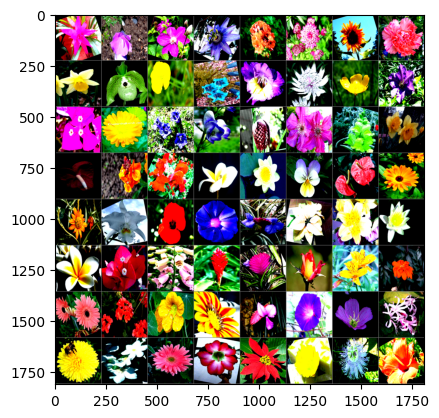

In [9]:
# functions to show an image
def imshow(img):
    img = img / 2 + 0.5
    np.clip(img, 0, 255)
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [10]:
if torch.cuda.is_available():
    device = 'cuda:0'
    print("[INFO] Current device:", torch.cuda.get_device_name(torch.cuda.current_device()), f", device num:{torch.cuda.current_device()}")
elif torch.has_mps:
    device = 'mps'
    print("[INFO] Current device: MAC OS Metal Performance Shaders.")
else:
    device = 'cpu'
    print("[INFO] Current device: CPU")
    print("*"*50,"\n[WARNING] You may need to change the device to GPU or MPS to get better performance.")
    print("*"*50)
device = torch.device(device)

[INFO] Current device: NVIDIA GeForce RTX 4090 , device num:0


# 2. Define a ResNet Network

In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ResBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.downsample = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        residual = self.downsample(x)
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out += residual
        out = self.relu(out)
        return out

class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=102):
        super(ResNet, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc1 = nn.Linear(512, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 102)

    def _make_layer(self, block, out_channels, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_channels, out_channels, stride))
            self.in_channels = out_channels
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
def ResNet34(num_classes):
    return ResNet(ResBlock, [3, 4, 6, 3], num_classes)
model = ResNet34(num_classes=102) 

# 3. Define a Loss function and optimizer

In [12]:
from torch.optim.lr_scheduler import StepLR

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
scheduler = StepLR(optimizer, step_size=20, gamma=0.5)

# 4. Train the network


In [13]:
EPOCHS = 150
losses = []
avg_loss = []
accuracy_value = []

for epoch in range(EPOCHS):

    model.cuda()
    model.train()
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):

        inputs, labels = data[0].to(device), data[1].cuda()
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs).cuda()
        loss = criterion(outputs, labels)
        losses.append(loss.item())
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        if i == 0:
            print(f"\n[Epoch:{epoch+1}]")

        print(f"\r\t\tBatch:{i+1:03} of {len(trainloader)}, loss:{loss.item():.5f}", end='')

    average_epoch_loss = running_loss / len(trainloader)
    avg_loss.append (running_loss / len(trainloader))
    print(f"\n\t\t Average Loss: {average_epoch_loss:.4f}")
    running_loss = 0.0
    correct = 0
    total = 0
    model.eval()
    with torch.no_grad():
        for data in testloader:
                               images, labels = data
                               outputs = model(images.to(device))
                               _, predicted = torch.max(outputs.data, 1)
                               total += labels.size(0)
                               correct += (predicted.cpu() == labels).sum().item()
    print('Accuracy of the network on the Flower102 test images: %d %%' % ( 100 * correct / total))
    accuracy_value.append (100 * correct / total)

print('\nFinished Training')


[Epoch:1]
		Batch:193 of 193, loss:3.55811
		 Average Loss: 4.0227
Accuracy of the network on the Flower102 test images: 5 %

[Epoch:2]
		Batch:193 of 193, loss:2.81587
		 Average Loss: 3.3138
Accuracy of the network on the Flower102 test images: 10 %

[Epoch:3]
		Batch:193 of 193, loss:3.02496
		 Average Loss: 2.8994
Accuracy of the network on the Flower102 test images: 18 %

[Epoch:4]
		Batch:193 of 193, loss:2.10826
		 Average Loss: 2.5272
Accuracy of the network on the Flower102 test images: 24 %

[Epoch:5]
		Batch:193 of 193, loss:2.84907
		 Average Loss: 2.2301
Accuracy of the network on the Flower102 test images: 25 %

[Epoch:6]
		Batch:193 of 193, loss:1.57341
		 Average Loss: 1.9716
Accuracy of the network on the Flower102 test images: 35 %

[Epoch:7]
		Batch:193 of 193, loss:3.39420
		 Average Loss: 1.7694
Accuracy of the network on the Flower102 test images: 40 %

[Epoch:8]
		Batch:193 of 193, loss:1.91832
		 Average Loss: 1.5161
Accuracy of the network on the Flower102 tes

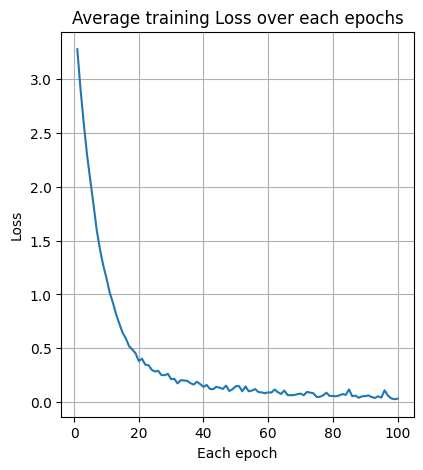

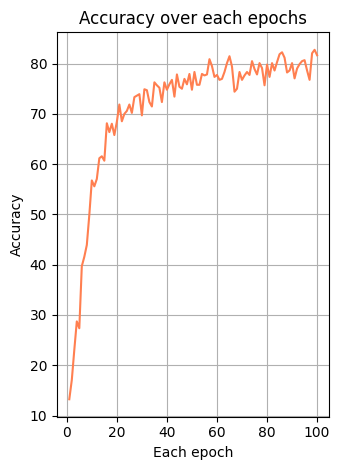

In [10]:
# Loss 可視化圖表
plt.figure(figsize=(10, 5))
plt.subplot(1,2,1)
plt.plot(range(1,len(avg_loss)+1),avg_loss,linestyle='-')
plt.xlabel('Each epoch')
plt.ylabel('Loss')
plt.title('Average training Loss over each epochs')
plt.grid()
plt.show()

# Accuracy 可視化圖表
plt.subplot(1,2,2)
plt.plot( range(1,len(accuracy_value)+1),accuracy_value,linestyle='-',color='coral')
plt.xlabel('Each epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy over each epochs')
plt.tight_layout()
plt.grid()
plt.show()

# 5. Test the network on the test data  


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


GroundTruth:  pink primrose pink primrose pink primrose pink primrose


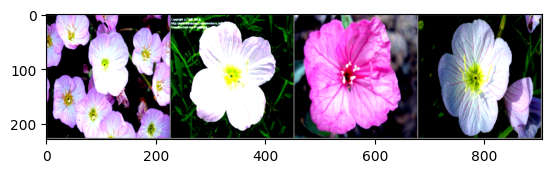

In [14]:
dataiter = iter(testloader)
images, labels = next(dataiter)

# print images
imshow(torchvision.utils.make_grid(images[:4]))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [16]:
model.eval()
with torch.no_grad():
     outputs = model(images.to(device))

In [17]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]] for j in range(4)))

Predicted:  camellia pink primrose bougainvillea pink primrose


In [19]:
class_correct = list(0. for i in range(102))
class_total = list(0. for i in range(102))
preds = np.zeros((1))
truth = np.zeros((1))
model.eval()
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = model(images.to(device))
        _, predicted = torch.max(outputs, 1)
        c = (predicted.cpu() == labels).squeeze()
        preds = np.concatenate([preds, predicted.cpu().numpy()], axis=0)
        truth = np.concatenate([truth, labels.numpy()], axis=0)
        for i in range(len(labels)):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1
for i in range(102):
        print('Accuracy of %5s : %2d %%' % (classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of pink primrose : 60 %
Accuracy of hard-leaved pocket orchid : 100 %
Accuracy of canterbury bells : 30 %
Accuracy of sweet pea : 30 %
Accuracy of english marigold : 90 %
Accuracy of tiger lily : 70 %
Accuracy of moon orchid : 100 %
Accuracy of bird of paradise : 100 %
Accuracy of monkshood : 90 %
Accuracy of globe thistle : 60 %
Accuracy of snapdragon : 80 %
Accuracy of colt's foot : 100 %
Accuracy of king protea : 90 %
Accuracy of spear thistle : 80 %
Accuracy of yellow iris : 90 %
Accuracy of globe-flower : 50 %
Accuracy of purple coneflower : 100 %
Accuracy of peruvian lily : 90 %
Accuracy of balloon flower : 30 %
Accuracy of giant white arum lily : 50 %
Accuracy of fire lily : 100 %
Accuracy of pincushion flower : 90 %
Accuracy of fritillary : 70 %
Accuracy of red ginger : 70 %
Accuracy of grape hyacinth : 50 %
Accuracy of corn poppy : 100 %
Accuracy of prince of wales feathers : 100 %
Accuracy of stemless gentian : 40 %
Accuracy of artichoke : 100 %
Accuracy of sweet wil

In [20]:
correct = 0
total = 0
model.eval()
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = model(images.to(device))
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted.cpu() == labels).sum().item()

print('Accuracy of the network on the Flower102 test images: %d %%' % ( 100 * correct / total))

Accuracy of the network on the Flower102 test images: 80 %


Display the confusion matrix as a heatmap

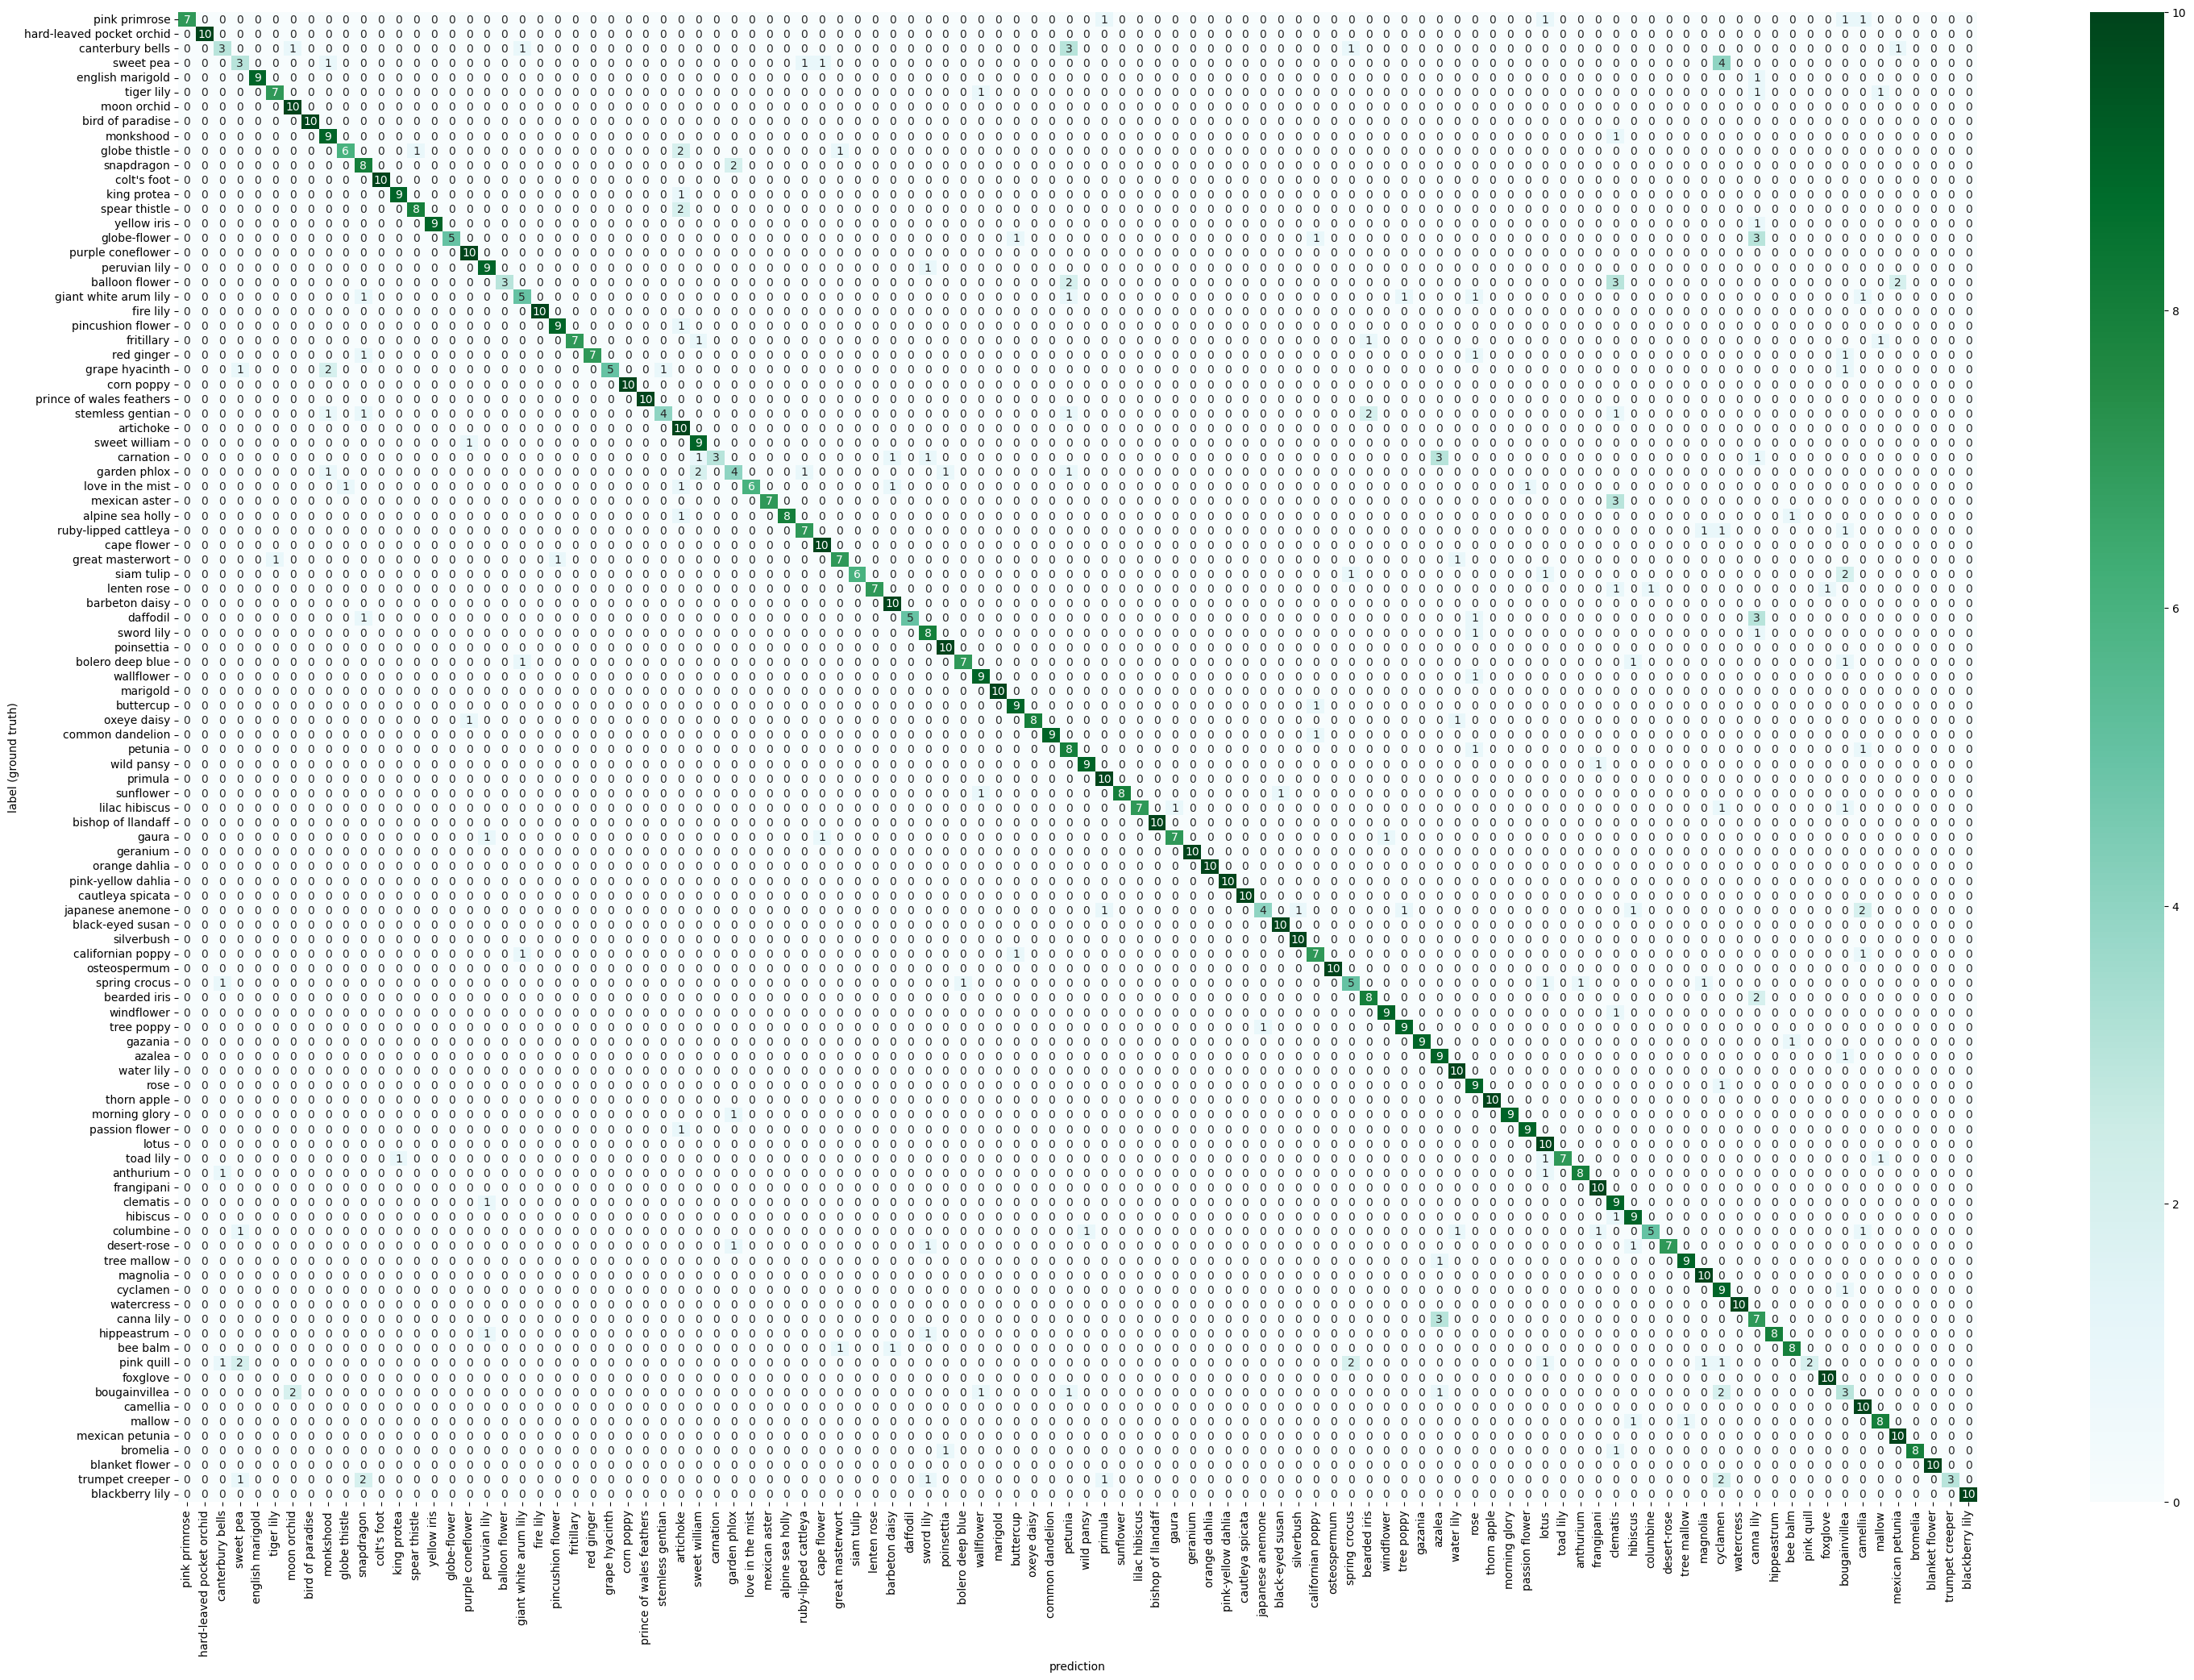

In [21]:
import pandas as pd
import seaborn as sns
from sklearn.metrics import confusion_matrix
# Display the confusion matrix as a heatmap
arr = confusion_matrix(truth, preds)
class_names = ['pink primrose', 'hard-leaved pocket orchid', 'canterbury bells', 'sweet pea',
           'english marigold', 'tiger lily', 'moon orchid', 'bird of paradise', 'monkshood', 'globe thistle',
           'snapdragon', "colt's foot", 'king protea', 'spear thistle', 'yellow iris',
           'globe-flower', 'purple coneflower', 'peruvian lily', 'balloon flower', 'giant white arum lily',
           'fire lily', 'pincushion flower', 'fritillary', 'red ginger', 'grape hyacinth', 'corn poppy',
           'prince of wales feathers', 'stemless gentian', 'artichoke', 'sweet william', 'carnation',
           'garden phlox', 'love in the mist', 'mexican aster', 'alpine sea holly', 'ruby-lipped cattleya',
           'cape flower', 'great masterwort', 'siam tulip', 'lenten rose', 'barbeton daisy', 'daffodil',
           'sword lily', 'poinsettia', 'bolero deep blue', 'wallflower', 'marigold', 'buttercup',
           'oxeye daisy', 'common dandelion', 'petunia', 'wild pansy', 'primula', 'sunflower',
           'lilac hibiscus', 'bishop of llandaff', 'gaura', 'geranium', 'orange dahlia', 'pink-yellow dahlia',
           'cautleya spicata', 'japanese anemone', 'black-eyed susan', 'silverbush', 'californian poppy', 'osteospermum',
           'spring crocus', 'bearded iris', 'windflower', 'tree poppy', 'gazania', 'azalea', 'water lily',
           'rose', 'thorn apple', 'morning glory', 'passion flower', 'lotus', 'toad lily', 'anthurium',
           'frangipani', 'clematis', 'hibiscus', 'columbine', 'desert-rose', 'tree mallow', 'magnolia', 'cyclamen',
           'watercress', 'canna lily', 'hippeastrum', 'bee balm', 'pink quill', 'foxglove', 'bougainvillea', 'camellia',
           'mallow', 'mexican petunia', 'bromelia', 'blanket flower', 'trumpet creeper', 'blackberry lily']
df_cm = pd.DataFrame(arr, class_names, class_names)
plt.figure(figsize = (36,24))
sns.heatmap(df_cm, annot=True, fmt="d", cmap='BuGn')
plt.xlabel("prediction")
plt.ylabel("label (ground truth)")
plt.show()

In [22]:
from sklearn.metrics import classification_report
print(classification_report(truth, preds, target_names=class_names))

                           precision    recall  f1-score   support

            pink primrose       1.00      0.64      0.78        11
hard-leaved pocket orchid       1.00      1.00      1.00        10
         canterbury bells       0.50      0.30      0.37        10
                sweet pea       0.38      0.30      0.33        10
         english marigold       1.00      0.90      0.95        10
               tiger lily       0.88      0.70      0.78        10
              moon orchid       0.77      1.00      0.87        10
         bird of paradise       1.00      1.00      1.00        10
                monkshood       0.64      0.90      0.75        10
            globe thistle       0.86      0.60      0.71        10
               snapdragon       0.57      0.80      0.67        10
              colt's foot       1.00      1.00      1.00        10
              king protea       0.90      0.90      0.90        10
            spear thistle       0.89      0.80      0.84     